## Spiking network analysis - Figure 5

Before you run the code in this notebook, you need to compile and run the simulations.

```
export SEED=123
export TAU=600
./run_snn.sh 0 0 $TAU $SEED
./run_snn_fixed_inh.sh 0 0 $TAU $SEED
./run_snn_feedforward.sh 0 0 $TAU $SEED
./run_snn.sh 0 1 $TAU $SEED
./run_snn_fixed_inh.sh 0 1 $TAU $SEED
./run_snn_feedforward.sh 0 1 $TAU $SEED
./run_snn.sh 1 0 $TAU $SEED
./run_snn_fixed_inh.sh 1 0 $TAU $SEED
./run_snn_feedforward.sh 1 0 $TAU $SEED
./run_snn.sh 1 1 $TAU $SEED
./run_snn_fixed_inh.sh 1 1 $TAU $SEED
./run_snn_feedforward.sh 1 1 $TAU $SEED
```

These simulations can take a long time (hours to days). If you would like to experiment, you can run simulations with an optimizer like RMSprop to speed up learning which allows simulating for shorter durations. You find an example call in this script `./run_snn_augmented_grad.sh`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import sys, os
import tqdm
import seaborn as sns
import scipy
from cycler import cycler
from itertools import repeat

from sklearn.decomposition import PCA

import subprocess

from scipy.sparse import *
from scipy.io import mmread

In [2]:
auryn_path = os.path.expanduser("~/auryn/") # Set this path to your local Auryn root directory
tool_path = auryn_path+"/tools/python/auryntools"

In [3]:
# Import auryn tools
import importlib.util
spec = importlib.util.spec_from_file_location("file_access", "%s/file_access.py"%tool_path)
auf = importlib.util.module_from_spec(spec)
spec.loader.exec_module(auf)
spec = importlib.util.spec_from_file_location("stats", "%s/stats.py"%tool_path)
aust = importlib.util.module_from_spec(spec)
spec.loader.exec_module(aust)


input_group_size = 100
dt      = 25e-3
duration = 100.0

In [4]:
outputdir = os.path.expanduser("~/data/lpl/plots/fig_spiking")
os.makedirs(outputdir, exist_ok=True)

In [5]:
suppl_outputdir = os.path.expanduser("~/data/lpl/plots/suppl_fig_spiking")
os.makedirs(suppl_outputdir, exist_ok=True)

In [6]:
from sklearn import linear_model
from sklearn.metrics import r2_score


def split_dataset(dataset, split=0.8, shuffle=False):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [7]:
def get_binned_data(data_path, nb_inputs=500, nb_units=100, test_split=0.05, t_start=None, bin_duration=None):
    # print("Processing %s ..."%data_path)
    sin  = auf.AurynBinarySpikeView('%s/input_group.*.spk'%data_path)
    exc_out = auf.AurynBinarySpikeView('%s/exc.*.spk'%data_path)
    
    if t_start is None:
        t_start = sin.t_max-duration
    t_end   = t_start+duration
    print("t_start=%f, t_end=%f"%(t_start,t_end))

    input_spikes = sin.get_spikes(t_start, t_end)
    exc_spikes   = exc_out.get_spikes(t_start, t_end)

    if bin_duration is None:
        bin_duration = dt

    # Bin data ...
    binned_hidden = np.zeros((int((t_end-t_start)/bin_duration),nb_units))
    for t,i in exc_spikes:
        idx = int((t-t_start-1e-4)//bin_duration)
        binned_hidden[idx,i] += 1.0
    
    binned_input = np.zeros((int((t_end-t_start)/bin_duration),nb_inputs//input_group_size))
    for t,i in input_spikes:
        idx = int((t-t_start-1e-4)//bin_duration)
        binned_input[idx,i//input_group_size] += 1.0
    
    return binned_hidden,binned_input


def get_r2_values(data_path, nb_inputs=500, nb_units=100, test_split=0.05, t_start=None, return_test_r2=False):
    
    # Prepare dataset for Lasso
    X,Y = get_binned_data(data_path, nb_inputs=nb_inputs, nb_units=nb_units, t_start=t_start)
    
    res = []
    for g in range(5):
        dataset = (X,Y[:,g])
        ds_train, ds_test = split_dataset(dataset,split=1.0-test_split)

        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(*ds_train)

        y_pred_lasso = lasso.predict(ds_test[0])
        r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
        res.append(r2_score_lasso)

    dataset = (X,Y)
    ds_train, ds_test = split_dataset(dataset, split=1.0-test_split)

    lasso = linear_model.Lasso(alpha=0.1)
    lasso.fit(*ds_train)

    y_pred_lasso = lasso.predict(ds_test[0])
    r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
   
    if return_test_r2:
        return res, r2_score_lasso
    else:
        return res

def participation_ratio(x):
    """
    Calculates participation ratio of the correlation matrix of the input
    pr = (sum of eigenvalues)^2 / sum of (eigenvalues^2)
    :param x: input feature array (batch x features)
    :return: ndarray
             participation ratio (singleton tensor)
    """
    x_c = x - x.mean(axis=0)

    corr_matrix = np.einsum('ij,kj->ik', x_c, x_c)

    eig_vals, _ = np.linalg.eig(corr_matrix)
    eig_vals = eig_vals.real

    pr = eig_vals.sum() ** 2 / (eig_vals ** 2).sum()

    return pr

In [8]:
# colors = ['gray', '#4393C3', '#4393C3', '#D6604D', '#D6604D']

colors = ['gray', '#81226A', '#81226A', '#058585', '#058585']
alphas = [1., 1., 0.5, 1., 0.5]

In [9]:
def bin_weights_per_input_group(w_mat, nb_inputs=500, nb_groups=5):
    nb_elements_per_group = nb_inputs//nb_groups
    idxs = np.array([nb_elements_per_group*(i+1) for i in range(nb_groups)]) - 1

    sums = np.insert(np.cumsum(w_mat, axis=0)[idxs], 0, 0, axis=0)
    slice_means = (sums[1:]-sums[:-1])/nb_elements_per_group

    return slice_means

In [10]:
duration

100.0

In [11]:
def analyze(data_path, outputdir, runid, nb_inputs=500, nb_units=100, test_split=0.05, t_start=None, inh=False, quiet=False):
    # print("Processing %s ..."%data_path)
    sin  = auf.AurynBinarySpikeView('%s/input_group.*.spk'%data_path)
    exc_out = auf.AurynBinarySpikeView('%s/exc.*.spk'%data_path)
    
    if t_start is None:
        t_start = sin.t_max-duration
    t_end   = t_start+duration
    print("t_start=%f, t_end=%f"%(t_start,t_end))

    input_spikes = sin.get_spikes(t_start, t_end)
    exc_spikes   = exc_out.get_spikes(t_start, t_end)
    # activity = np.zeros((int((t_end-t_start)/dt),nb_units))
    w_mat = mmread("%s/input_con.0.wmat"%data_path).toarray()
    w_mat = bin_weights_per_input_group(w_mat)


    spikes = exc_spikes

    # Bin data ...
    binned_hidden = np.zeros((int((t_end-t_start)/dt),nb_units))
    for t,i in exc_spikes:
        idx = int((t-t_start-1e-4)//dt)
        binned_hidden[idx,i] += 1.0
    
    binned_input = np.zeros((int((t_end-t_start)/dt),nb_inputs//input_group_size))
    for t,i in input_spikes:
        idx = int((t-t_start-1e-4)//dt)
        binned_input[idx,i//input_group_size] += 1.0
        
    # Prepare dataset
    X = binned_hidden
    Y = binned_input
    
    res = []
    for g in range(5):
        dataset = (X,Y[:,g])
        ds_train, ds_test = split_dataset(dataset,split=1.0-test_split)

        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(*ds_train)

        y_pred_lasso = lasso.predict(ds_test[0])
        r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
        if not quiet:
            print("r2 on test %i data : %f" %(g, r2_score_lasso))
        res.append(r2_score_lasso)
        
    dataset = (X,Y)
    ds_train, ds_test = split_dataset(dataset, split=1.0-test_split)

    lasso = linear_model.Lasso(alpha=0.1)
    lasso.fit(*ds_train)

    y_pred_lasso = lasso.predict(ds_test[0])
    r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
    if not quiet:
        print("r2 on test data : %f" %(r2_score_lasso))
        
    # print("Plotting data ...")
    marker_size = 0.8
    lw = 0.5
    alpha = 0.7

    if t_start is None:
        t_start = sin.t_max-test_split*duration # only plot the held out test data
    else:
        t_start = t_end-test_split*duration # only plot the held out test data
    t_dur = t_end-t_start
    input_spikes = sin.get_spikes(t_start, t_end)
    exc_spikes   = exc_out.get_spikes(t_start, t_end)
    # inh_spikes   = inh_out.get_spikes(t_start, t_end)
    if inh:
        inh_out = auf.AurynBinarySpikeView('%s/inh.*.spk'%data_path)
        inh_spikes = inh_out.get_spikes(t_start, t_end)
    
    fig = plt.figure(figsize=(4.2,3), dpi=150)
    gs = GridSpec(2,3, width_ratios=[2,1,0.3])
    
    plt.subplot(gs[0])
    plt.title("Input spikes", fontsize=10)
    ar = np.array(input_spikes)
    plt.scatter(ar[:,0]-t_start, ar[:,1], marker='|', s=marker_size, alpha=0.4, c='black', linewidths=lw)
    plt.xlim((0, t_dur))
    plt.ylim((0, nb_inputs))
    plt.ylabel('Input spikes', fontsize=8)
    plt.axis("off")
    
    offset = 50
    offs = np.arange(5)*offset
    plt.subplot(gs[1])
    for i in range(5):
        plt.plot(ds_test[1][:,i]+offs[i], color=colors[i], alpha=alphas[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Binned input')
    plt.title("Input signals", fontsize=10)
    plt.ylim((0,5*offset))
    plt.axis("off")
   
    
    plt.subplot(gs[3])
    if inh and len(inh_spikes):
        ar = np.array(inh_spikes)
        plt.scatter(ar[:,0]-t_start, ar[:,1], marker='|', s=marker_size, alpha=alpha, c='#020072', linewidths=lw)
    if len(exc_spikes):
        ar = np.array(exc_spikes)
        plt.scatter(ar[:,0]-t_start, 30 + ar[:,1], marker='|', s=marker_size, alpha=alpha, c='black', linewidths=lw)
    plt.xlim((0, t_dur))
    # plt.ylim((,100))
    plt.title("Network activity", fontsize=10)
    plt.ylabel('Neurons')
    plt.axis("off")
    
    

    plt.subplot(gs[4])    
    plt.title("Reconstruction", fontsize=10)
    for i in range(5):
        plt.plot(y_pred_lasso[:,i]+offs[i], color=colors[i], alpha=alphas[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Reconstruction')
    plt.ylim((0,5*offset))
    plt.axis("off")
    
    
    ax = plt.subplot(gs[5])  
    y_pos = np.arange(5)
    ax.barh(y_pos, res, color="gray", align="center")
    ax.set_yticks([])
    # ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('$R^2$', fontsize=10, labelpad=-1)
    ax.set_xlim((0,1.0))
    # ax.set_title('How fast do you want to go today?')
    
    # ax=plt.subplot(gs[2])
    # # ax.set_title('Weights')
    # y_pos = np.arange(5)
    # ax.barh(y_pos, w_mat.mean(-1), color="gray", align="center")
    # ax.set_yticks([])
    # # ax.invert_yaxis()  # labels read top-to-bottom
    # ax.set_xlabel('learned $w$', fontsize=8)
    # ax.set_xlim((0,0.1))
    

    sns.despine()
    plt.tight_layout()
    plt.savefig("%s/%s_fig.png"%(outputdir,runid))
    plt.savefig("%s/%s_fig.pdf"%(outputdir,runid))
    # plt.close(fig)
    
    C = np.corrcoef(y_pred_lasso.ravel(), ds_test[1].ravel())
    corr = C[0,1]
    print("IO correlation %f"%corr)
    return res

# analyze("../recrun", outputdir, "recurrent")

t_start=10.000000, t_end=110.000000
IO correlation 0.227224
t_start=101699.999100, t_end=101799.999100
IO correlation 0.772785


[-0.00037459665190042735,
 0.8073462109464096,
 0.0015716294833875155,
 0.8371562535688821,
 -0.006984465310504451]

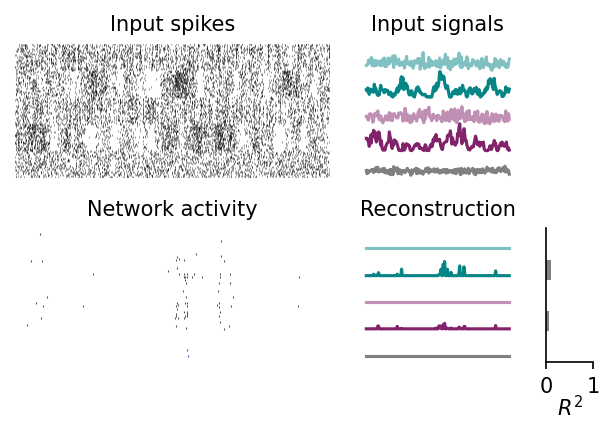

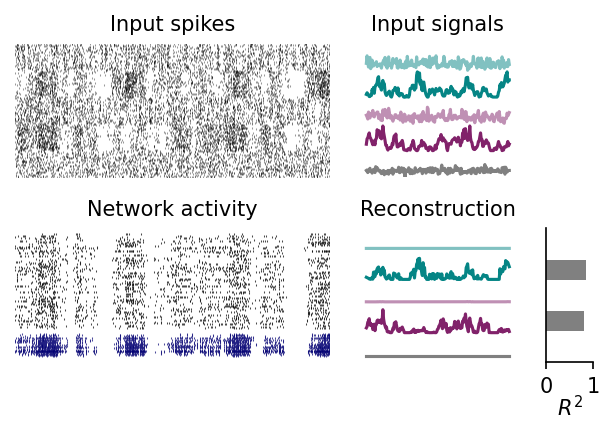

In [12]:
nb_units = 100
filename = os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/recurrent/")

analyze(filename, outputdir, "test_start", nb_units=nb_units, t_start=10, inh=True, quiet=True)
analyze(filename, outputdir, "test_end", nb_units=nb_units, inh=True, quiet=True)

t_start=10.000000, t_end=110.000000
IO correlation 0.227324
t_start=101699.999100, t_end=101799.999100
IO correlation 0.790112


[0.015690250868068523,
 0.776651277231019,
 0.1798512465325146,
 0.8234068464041783,
 0.19176338327792508]

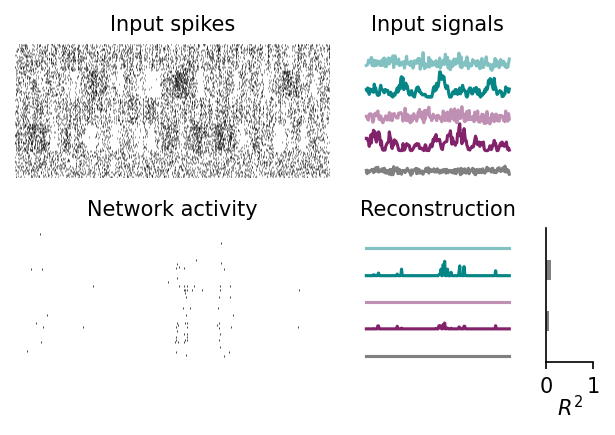

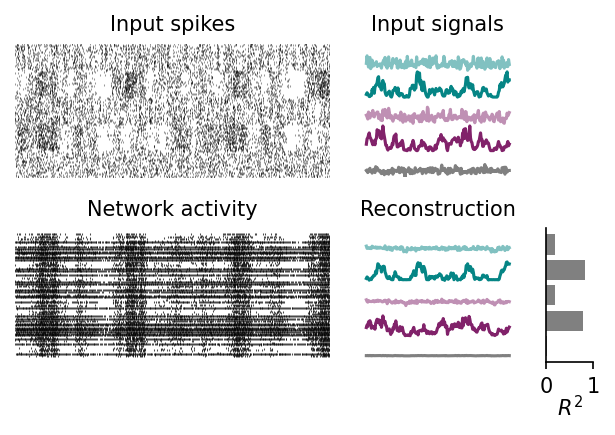

In [13]:
nb_units = 100
filename = os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/feedforward/")

analyze(filename, outputdir, "test_start", nb_units=nb_units, t_start=10, inh=False, quiet=True)
analyze(filename, outputdir, "test_end", nb_units=nb_units, inh=False, quiet=True)

In [14]:
base_path = os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/recurrent/")
w_inh = mmread(base_path+"/con_ie.0.wmat").toarray()

In [15]:
# base_path = os.path.expanduser("~/data/lpl/spiking_no_ei_plasticity/tau600_lam1_phi1/recurrent/")
# w_inh = mmread(base_path+"/con_ie.0.wmat").toarray()

## Extract some useful statistics

In [16]:
t_start = 99900
t_end   = 100000

nb_units = 100

def read_results(data_path, t1=t_start, t2=t_end):

    # prate = np.loadtxt('%s/exc.0.prate'%(data_path))[-1][1]
    # rates = prate
    exc_out = auf.AurynBinarySpikeView('%s/exc.*.spk'%data_path)
    exc_spikes   = exc_out.get_spikes(t1, t2)
    # rates = aust.rates(exc_spikes)
    rates = np.zeros(nb_units)
    for spike in exc_spikes:
        rates[spike[1]] += 1
    rates /= 100.

    X,Y = get_binned_data(data_path, t_start=t1)
    pr = participation_ratio(X)

    w_mat = mmread("%s/input_con.0.wmat"%data_path).toarray()
    w_mat = bin_weights_per_input_group(w_mat)
    
    corrs = np.zeros(5)
    for j in range(5):
        corrs[j] = np.corrcoef(X.ravel(), Y[:,j].repeat(100).ravel())[0,1]

    return rates, pr, w_mat, corrs

In [17]:
lams = ['0', '1']
# lams = ['1'] # FIXME remove this line
lam_vals = np.array([float(lam) for lam in lams])

In [18]:
base_path = os.path.expanduser("~/data/lpl/spiking/")

rates_lpl = np.zeros((len(lams), nb_units))
# rates_lpl = np.zeros(len(lams))
dim_lpl = np.zeros(len(lams))
weights_lpl = np.zeros((len(lams), 5, nb_units))
corrs_lpl = np.zeros((len(lams), 5))

for i, lam in enumerate(lams):
    data_path = base_path+"tau600_lam%s_phi1/recurrent/"%lam
    rates_lpl[i], dim_lpl[i], weights_lpl[i], corrs_lpl[i] = read_results(data_path)

t_start=99900.000000, t_end=100000.000000
t_start=99900.000000, t_end=100000.000000


In [19]:
base_path = os.path.expanduser("~/data/lpl/spiking/")

rates_pred_off = np.zeros((len(lams), nb_units))
# rates_pred_off = np.zeros(len(lams))
dim_pred_off = np.zeros(len(lams))
weights_pred_off = np.zeros((len(lams), 5, nb_units))
corrs_pred_off = np.zeros((len(lams), 5))

for i, lam in enumerate(lams):
    data_path = base_path+"tau600_lam%s_phi0/recurrent/"%lam
    rates_pred_off[i], dim_pred_off[i], weights_pred_off[i], corrs_pred_off[i] = read_results(data_path)

t_start=99900.000000, t_end=100000.000000
t_start=99900.000000, t_end=100000.000000


In [20]:
base_path = os.path.expanduser("~/data/lpl/spiking/")

rates_ff = np.zeros((len(lams), nb_units))
# rates_ff = np.zeros(len(lams))
dim_ff = np.zeros(len(lams))
weights_ff = np.zeros((len(lams), 5, nb_units))
corrs_ff = np.zeros((len(lams), 5))

for i, lam in enumerate(lams):
    data_path = base_path+"tau600_lam%s_phi1/feedforward/"%lam
    rates_ff[i], dim_ff[i], weights_ff[i], corrs_ff[i] = read_results(data_path)

t_start=99900.000000, t_end=100000.000000
t_start=99900.000000, t_end=100000.000000


In [21]:
base_path = os.path.expanduser("~/data/lpl/spiking_no_ei_plasticity/")

rates_fixed_inhib = np.zeros((len(lams), nb_units))
# rates_fixed_inhib = np.zeros(len(lams))
dim_fixed_inhib = np.zeros(len(lams))
weights_fixed_inhib = np.zeros((len(lams), 5, nb_units))
corrs_fixed_inhib = np.zeros((len(lams), 5))

for i, lam in enumerate(lams):
    data_path = base_path+"tau600_lam%s_phi1/recurrent/"%lam
    rates_fixed_inhib[i], dim_fixed_inhib[i], weights_fixed_inhib[i], corrs_fixed_inhib[i] = read_results(data_path)

t_start=99900.000000, t_end=100000.000000
t_start=99900.000000, t_end=100000.000000


In [22]:
def relative_vals(vals, i, j):
    return (vals[:,i]-vals[:,j])/(vals[:,i]+vals[:,j] + 1e-9)

## Panels spiking figure

t_start=101699.999100, t_end=101799.999100
IO correlation 0.772785


[-0.00037459665190042735,
 0.8073462109464096,
 0.0015716294833875155,
 0.8371562535688821,
 -0.006984465310504451]

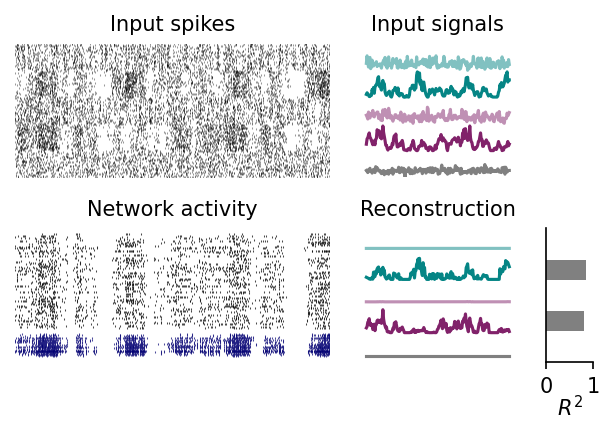

In [23]:
nb_units = 100
filename = os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/recurrent/")
outputdir = os.path.expanduser("~/data/lpl/plots/fig_spiking")

analyze(filename, outputdir, "diff_slowness", nb_units=nb_units, inh=True, quiet=True)

In [24]:
slow_signal_index = 3
slow_shuffled_index = 4

fast_signal_index = 1
fast_shuffled_index = 2

control_index = 0

idx = np.where(lam_vals==1)
hebb_off_idx = np.where(lam_vals==0)

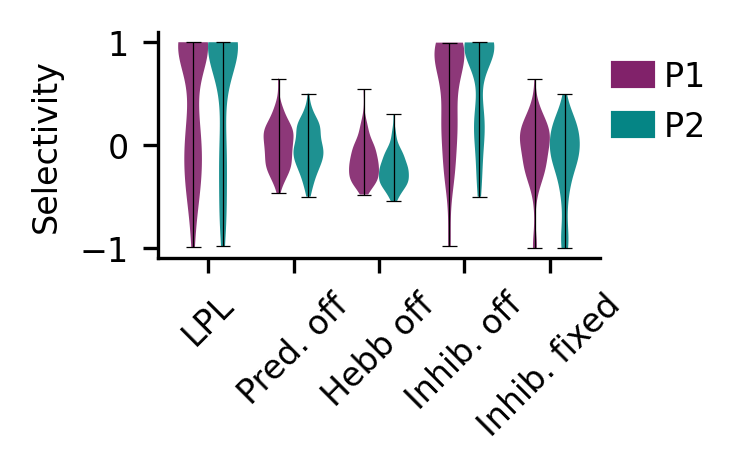

In [25]:
plt.figure(figsize=(1.9, 1.), dpi=300)
barWidth = 0.35

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]
offsets = (2*np.random.random(100)-1)/10.
dotsize = 1

# LPL
selectivity_slow = relative_vals(weights_lpl, slow_signal_index, slow_shuffled_index)[idx]
selectivity_fast = relative_vals(weights_lpl, fast_signal_index, fast_shuffled_index)[idx]

# Pred. off
selectivity_slow_pred_off = relative_vals(weights_pred_off, slow_signal_index, slow_shuffled_index)[idx]
selectivity_fast_pred_off = relative_vals(weights_pred_off, fast_signal_index, fast_shuffled_index)[idx]

# Hebb off
selectivity_slow_hebb_off = relative_vals(weights_lpl, slow_signal_index, slow_shuffled_index)[hebb_off_idx]
selectivity_fast_hebb_off = relative_vals(weights_lpl, fast_signal_index, fast_shuffled_index)[hebb_off_idx]

# Inhib. off
selectivity_slow_inhib_off = relative_vals(weights_ff, slow_signal_index, slow_shuffled_index)[idx]
selectivity_fast_inhib_off = relative_vals(weights_ff, fast_signal_index, fast_shuffled_index)[idx]

# Fixed inhib.
selectivity_slow_fixed_inhib = relative_vals(weights_fixed_inhib, slow_signal_index, slow_shuffled_index)[idx]
selectivity_fast_fixed_inhib = relative_vals(weights_fixed_inhib, fast_signal_index, fast_shuffled_index)[idx]

violin_parts = plt.violinplot(np.array([selectivity_fast, selectivity_fast_pred_off, selectivity_fast_hebb_off, selectivity_fast_inhib_off, selectivity_fast_fixed_inhib]).squeeze().T, positions=r1, widths=barWidth)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[fast_signal_index])
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

patch_1 = mpatches.Patch(color=colors[fast_signal_index])
fake_handle_1 = repeat(patch_1, 1)



violin_parts = plt.violinplot(np.array([selectivity_slow, selectivity_slow_pred_off, selectivity_slow_hebb_off, selectivity_slow_inhib_off, selectivity_slow_fixed_inhib]).squeeze().T, positions=r2, widths=barWidth)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[slow_signal_index])
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

patch_2 = mpatches.Patch(color=colors[slow_signal_index])
fake_handle_2 = repeat(patch_2, 1)

handles = [patch_1, patch_2]
labels = ['P$1$', 'P$2$']
lgd = plt.legend(handles, labels, frameon=False, fontsize=8, loc=(1., 0.45), handlelength=1.2, handletextpad=0.3)

# plt.bar(r2, [selectivity_slow.mean(), selectivity_slow_pred_off.mean(), selectivity_slow_hebb_off.mean(), selectivity_slow_inhib_off.mean(), selectivity_slow_fixed_inhib.mean()], color=colors[slow_signal_index], width = barWidth, label='$P2$', capsize=2)

plt.ylabel('Selectivity', fontsize=8)
plt.xticks([r + 0.5*barWidth for r in range(len(r1))], ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
# lgd = plt.legend(frameon=False, fontsize=8, loc=(0.25, 0.5), handlelength=1.4)
plt.xticks(rotation=45, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# plt.yticks([0, 0.5])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_selectivity.pdf'), bbox_inches='tight')


### Weights

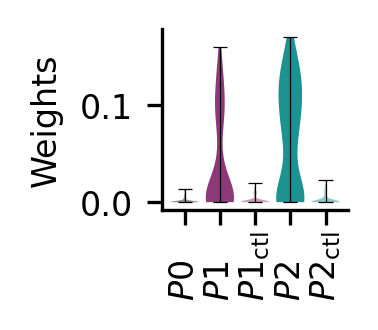

In [26]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_lpl[idx].squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()

plt.savefig(os.path.join(outputdir,'diff_slowness_weights_lpl.pdf'), bbox_inches='tight')

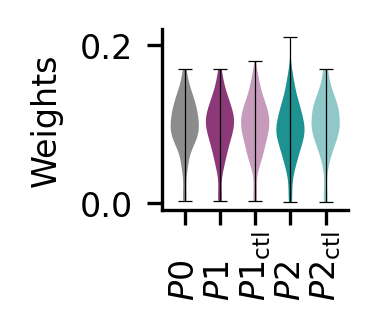

In [27]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
# plt.figure(figsize=(0.9, 0.9), dpi=300)
violin_parts = plt.violinplot(weights_pred_off[idx].squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_weights_pred_off.pdf'), bbox_inches='tight')

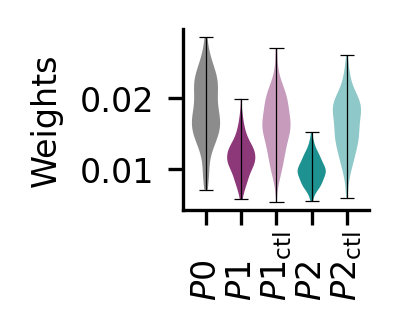

In [28]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
violin_parts = plt.violinplot(weights_lpl[hebb_off_idx].squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_weights_hebb_off.pdf'), bbox_inches='tight')

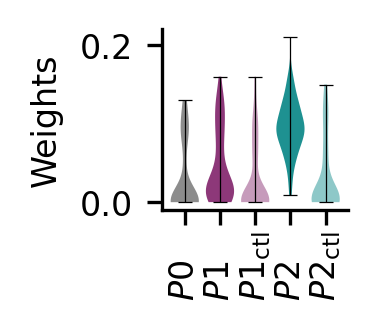

In [29]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
violin_parts = plt.violinplot(weights_ff[idx].squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_weights_inhib_off.pdf'), bbox_inches='tight')

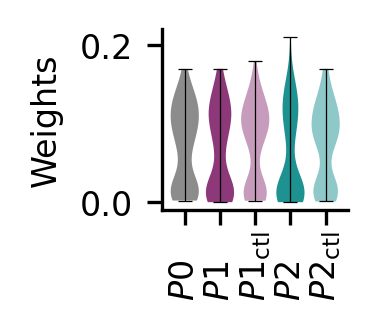

In [30]:
plt.figure(figsize=(0.8, 0.8), dpi=300)
violin_parts = plt.violinplot(weights_fixed_inhib[idx].squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(alphas[i]*0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

plt.ylabel('Weights', fontsize=8)
plt.xticks(np.arange(1,6), ['$P0$', '$P1$', '$P1_{\mathrm{ctl}}$', '$P2$', '$P2_{\mathrm{ctl}}$'], fontsize=8, rotation=90, va='bottom')
# plt.yticks([0, 0.05])
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize=8)
ax.tick_params(axis="x", pad=18)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_weights_inhib_fixed.pdf'), bbox_inches='tight')

### Activity

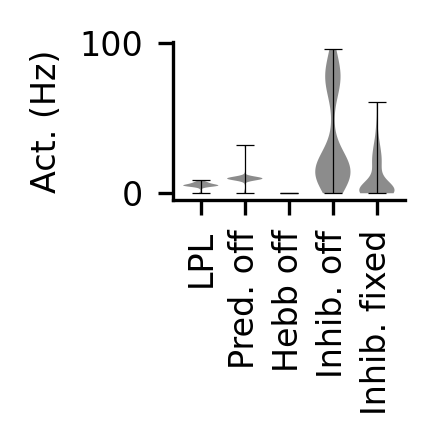

In [31]:
plt.figure(figsize=(1., 0.7), dpi=300)

barWidth = 0.55

r1 = np.arange(5)

violin_parts = plt.violinplot(np.array([rates_lpl[idx], rates_pred_off[idx], rates_lpl[hebb_off_idx], rates_ff[idx], rates_fixed_inhib[idx]]).squeeze().T, np.arange(1,6), widths=0.8)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor('gray')
    pc.set_alpha(0.9)

violin_parts['cbars'].set_color('black')
violin_parts['cbars'].set_linewidth(0.3)
violin_parts['cmins'].set_color('black')
violin_parts['cmins'].set_linewidth(0.3)
violin_parts['cmaxes'].set_color('black')
violin_parts['cmaxes'].set_linewidth(0.3)

# plt.bar(r1, [rates_lpl[idx].mean(), rates_pred_off[idx].mean(), rates_lpl[hebb_off_idx].mean(), rates_ff[idx].mean(), rates_fixed_inhib[idx].mean()], color ='gray', width = barWidth, capsize=1.2, error_kw = {'elinewidth':0.5, 'capthick':0.5}, yerr=[rates_lpl[idx].std()/10, rates_pred_off[idx].std()/10, rates_lpl[hebb_off_idx].std()/10, rates_ff[idx].std()/10, rates_fixed_inhib[idx].std()/10])
# plt.bar(r1, [rates_lpl[idx].mean(), rates_pred_off[idx].mean(), rates_lpl[hebb_off_idx].mean(), rates_ff[idx].mean(), rates_fixed_inhib[idx].mean()], color ='gray', width = barWidth)
plt.xticks(r1+1, ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
plt.ylabel('Act. (Hz)', fontsize=8)
plt.xticks(rotation=90, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
# ax.set_yscale('log')
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_activity.pdf'), bbox_inches='tight')

### Dimension

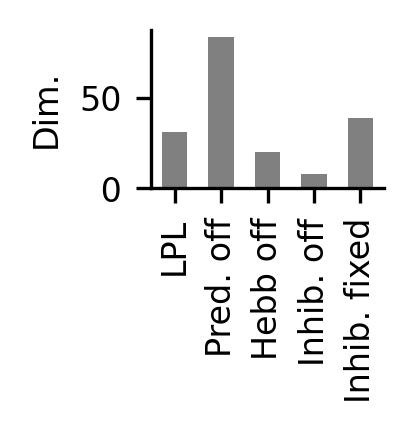

In [32]:
plt.figure(figsize=(1., 0.7), dpi=300)

barWidth = 0.55

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]

plt.bar(r1, [dim_lpl[idx][0], dim_pred_off[idx][0], dim_lpl[hebb_off_idx][0], dim_ff[idx][0], dim_fixed_inhib[idx][0]], color ='gray', width = barWidth, capsize=2)
plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Inhib. off', 'Inhib. fixed'], fontsize=8)
plt.ylabel('Dim.', fontsize=8)
plt.xticks(rotation=90, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
# ax.set_yscale('log')
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_dim.pdf'), bbox_inches='tight')

### Weight quivers

In [33]:
idx = np.where(lam_vals==1)
hebb_off_idx = np.where(lam_vals==0)

In [34]:
w_lpl = weights_lpl[idx].squeeze()
w_pred_off = weights_pred_off[idx].squeeze()
w_hebb_off = weights_ff[hebb_off_idx].squeeze()
w_ff = weights_ff[idx].squeeze()
w_fixed_inhib = weights_fixed_inhib[idx].squeeze()

In [35]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [36]:
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [37]:
def combine_hex_values(color_1, color_2, weights_1, weights_2):
    red = ((int(color_1[1:3], 16) * weights_1 + int(color_2[1:3], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    green = ((int(color_1[3:5], 16) * weights_1 + int(color_2[3:5], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    blue = ((int(color_1[5:7], 16) * weights_1 + int(color_2[5:7], 16) * weights_2)/(weights_1 + weights_2 + 1e-9)).astype(int)
    hex_codes = ['#%02x%02x%02x'%(r,g,b) for r,g,b in zip(red, green, blue)]
    return hex_codes

In [38]:
interp_colors = [colors[fast_signal_index], '#C0C0C0', colors[slow_signal_index]]
interp_values = [0, 0.5, 1]
divnorm = mcolors.TwoSlopeNorm(vmin=0, vcenter=np.pi/4, vmax=1)
cmap = get_continuous_cmap(interp_colors, interp_values)

In [39]:
def get_weighted_colors(weight_1, weight_2):
    angle = ((weight_1-weight_2)/(weight_1+weight_2+1e-9)+1)/2
    weighted_colors = cmap(angle)
    return weighted_colors

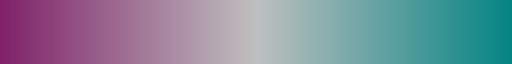

In [40]:
cmap

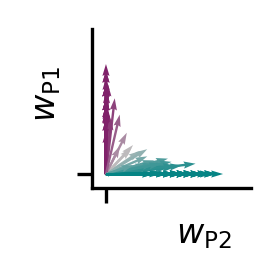

In [41]:
weighted_colors = get_weighted_colors(w_lpl[slow_signal_index], w_lpl[fast_signal_index])

x, y = np.meshgrid(np.zeros(10), np.zeros(10))
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_lpl[slow_signal_index], w_lpl[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_wt_quiver_lpl.pdf'), bbox_inches='tight')

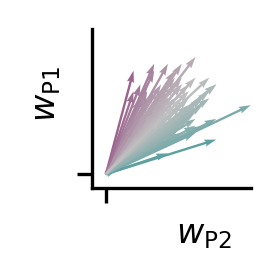

In [42]:
weighted_colors = get_weighted_colors(w_pred_off[slow_signal_index], w_pred_off[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_pred_off[slow_signal_index], w_pred_off[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_wt_quiver_pred_off.pdf'), bbox_inches='tight')

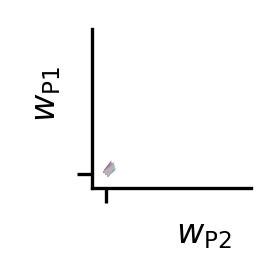

In [43]:
weighted_colors = get_weighted_colors(w_hebb_off[slow_signal_index], w_hebb_off[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_hebb_off[slow_signal_index], w_hebb_off[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_lpl[slow_signal_index].mean(), w_lpl[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_wt_quiver_hebb_off.pdf'), bbox_inches='tight')

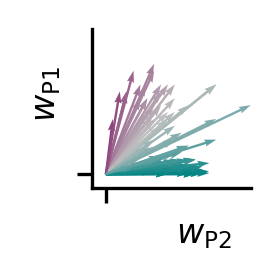

In [44]:
weighted_colors = get_weighted_colors(w_ff[slow_signal_index], w_ff[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_ff[slow_signal_index], w_ff[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_decorr_off[slow_signal_index].mean(), w_decorr_off[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_wt_quiver_inhib_off.pdf'), bbox_inches='tight')

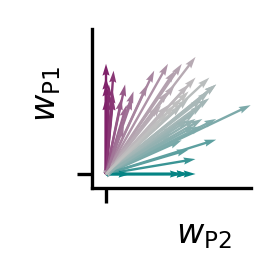

In [45]:
weighted_colors = get_weighted_colors(w_fixed_inhib[slow_signal_index], w_fixed_inhib[fast_signal_index])
plt.figure(figsize=(0.7,0.7), dpi=300)
plt.quiver(x, y, w_fixed_inhib[slow_signal_index], w_fixed_inhib[fast_signal_index], angles='xy', scale_units='xy', scale=1., color=weighted_colors, width=0.015)
# plt.axline((0, 0), (0.2, 0.2), color='gray', linestyle='dashed', linewidth=1)
# plt.quiver(0, 0, w_decorr_off[slow_signal_index].mean(), w_decorr_off[fast_signal_index].mean(), angles='xy', scale_units='xy', scale=1., color='k', width=0.02)
plt.axis('square')
plt.xlim(-0.02,0.21)
plt.ylim(-0.02,0.21)
plt.xlabel('$\quad \quad w_{\mathrm{P2}}$', fontsize=8, labelpad=0)
plt.ylabel('$\quad w_{\mathrm{P1}}$', fontsize=8, labelpad=0)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.yticks([0])
plt.xticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_wt_quiver_inhib_fixed.pdf'), bbox_inches='tight')

### Relative selectivities

In [46]:
rel_selectivity_lpl = relative_vals(weights_lpl, slow_signal_index, fast_signal_index)[idx].squeeze()
rel_selectivity_pred_off = relative_vals(weights_pred_off, slow_signal_index, fast_signal_index)[idx].squeeze()
rel_selectivity_hebb_off = relative_vals(weights_lpl, slow_signal_index, fast_signal_index)[hebb_off_idx].squeeze()
rel_selectivity_inhib_off = relative_vals(weights_ff, slow_signal_index, fast_signal_index)[idx].squeeze()
rel_selectivity_fixed_inhib = relative_vals(weights_fixed_inhib, slow_signal_index, fast_signal_index)[idx].squeeze()

In [47]:
rel_selectivity_lpl.shape

(100,)

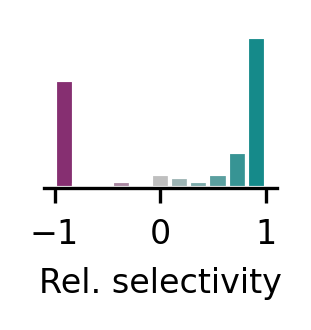

In [48]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_lpl, bins=11, edgecolor='white', color='teal', density=True)
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('LPL', fontsize=10)
plt.savefig(os.path.join(outputdir,'diff_slowness_rel_sel_hist_lpl.pdf'), bbox_inches='tight')

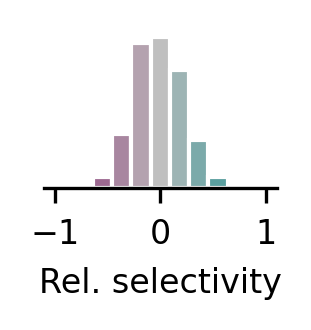

In [49]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_pred_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('Pred. off', fontsize=10)
plt.savefig(os.path.join(outputdir,'diff_slowness_rel_sel_hist_pred_off.pdf'), bbox_inches='tight')

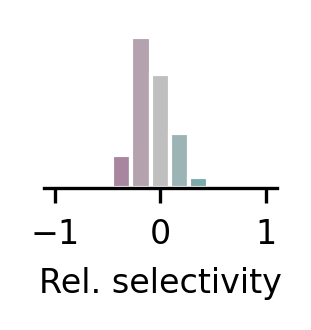

In [50]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_hebb_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
sns.despine()
# plt.ylim(0,40)
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
# plt.title('Hebb off', fontsize=10)
plt.savefig(os.path.join(outputdir,'diff_slowness_rel_sel_hist_hebb_off.pdf'), bbox_inches='tight')

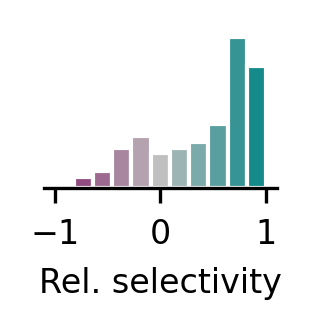

In [51]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_inhib_off, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
# plt.ylim(0,40)
sns.despine()
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'x', which = 'major', labelsize=8)
# plt.title('Inhib. off', fontsize=10)
plt.savefig(os.path.join(outputdir,'diff_slowness_rel_sel_hist_inhib_off.pdf'), bbox_inches='tight')

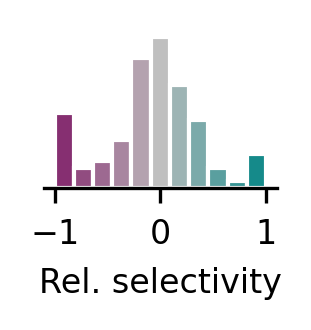

In [52]:
plt.figure(figsize=(1.,0.7), dpi=300)
N, bins, patches = plt.hist(rel_selectivity_fixed_inhib, bins=11, edgecolor='white', color='teal', density=True, range=(-1,1))
color_weights = (0.5*(bins[:-1]+bins[1:])+1)/2
weighted_colors = get_weighted_colors(color_weights, 1.-color_weights)
for i in range(len(N)):
    patches[i].set_facecolor(weighted_colors[i])
# plt.ylim(0,40)
sns.despine()
plt.xlabel('Rel. selectivity', fontsize=8)
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.tick_params(axis = 'x', which = 'major', labelsize=8)
# plt.title('Inhib. fixed', fontsize=10)
plt.savefig(os.path.join(outputdir,'diff_slowness_rel_sel_hist_inhib_fixed.pdf'), bbox_inches='tight')

### Firing rates

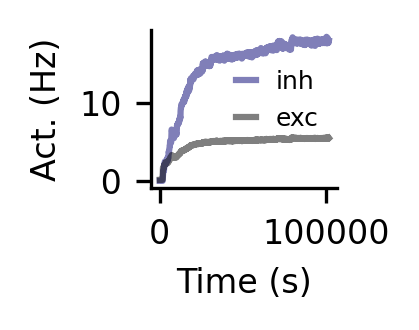

In [53]:
lam = 1
phi = 1
data_path = os.path.expanduser('~/data/lpl/spiking/tau600_lam%g_phi%g/recurrent/'%(lam,phi))
labels = ["inh", "exc"]
# colz = ["black", "#CA0000", "#0571b0"]
colz = ["#020072", "black"]
prates = [ np.loadtxt('%s/%s.0.prate'%(data_path,prefix)) for prefix in labels ]

fig=plt.figure(figsize=(0.8,0.7), dpi=300)
ax=plt.subplot(1,1,1)
for l,r,c in zip(labels,prates,colz):
    plt.plot(r[1:,0],r[1:,1],label=l,color=c,alpha=0.5)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
plt.legend(frameon=False, fontsize=6, handlelength=0.8, loc=(0.4, 0.3))
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Act. (Hz)", fontsize=8)
# plt.title('LPL', fontsize=10)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_rates_lpl.pdf'), bbox_inches='tight')

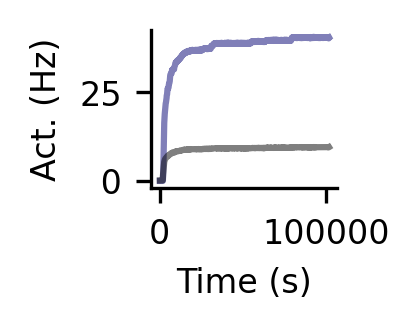

In [54]:
lam = 1
phi = 0
data_path = os.path.expanduser('~/data/lpl/spiking/tau600_lam%g_phi%g/recurrent/'%(lam,phi))
labels = ["inh", "exc"]
# colz = ["black", "#CA0000", "#0571b0"]
colz = ["#020072", "black"]
prates = [ np.loadtxt('%s/%s.0.prate'%(data_path,prefix)) for prefix in labels ]

fig=plt.figure(figsize=(0.8,0.7), dpi=300)
ax=plt.subplot(1,1,1)
for l,r,c in zip(labels,prates,colz):
    plt.plot(r[1:,0],r[1:,1],label=l,color=c,alpha=0.5)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%2d"))
# plt.legend(fontsize=6)
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Act. (Hz)", fontsize=8)
# plt.title('LPL', fontsize=10)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_rates_pred_off.pdf'), bbox_inches='tight')

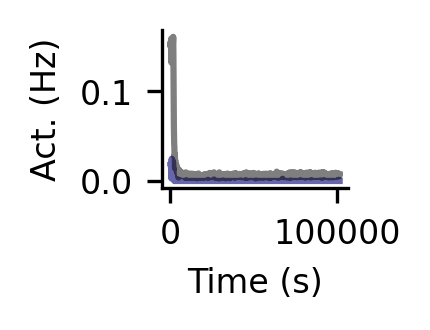

In [55]:
lam = 0
phi = 1
data_path = os.path.expanduser('~/data/lpl/spiking/tau600_lam%g_phi%g/recurrent/'%(lam,phi))
labels = ["inh", "exc"]
colz = ["#020072", "black"]
alphaz=[0.6, 0.5]
prates = [ np.loadtxt('%s/%s.0.prate'%(data_path,prefix)) for prefix in labels ]

fig=plt.figure(figsize=(0.8,0.7), dpi=300)
ax=plt.subplot(1,1,1)
for l,r,c,a in zip(labels,prates,colz,alphaz):
    plt.plot(r[1:,0],r[1:,1],label=l,color=c,alpha=a)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# plt.legend(frameon=False, fontsize=6, handlelength=0.8, loc=(0.4, 0.45))
# plt.ylim(0,3)
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Act. (Hz)", fontsize=8)
# plt.title('Hebb off', fontsize=10)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_rates_hebb_off.pdf'), bbox_inches='tight')

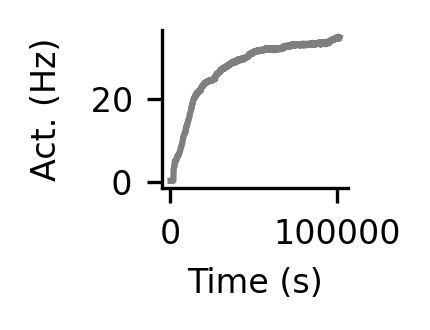

In [56]:
lam = 1
phi = 1
data_path = os.path.expanduser('~/data/lpl/spiking/tau600_lam%g_phi%g/feedforward/'%(lam,phi))
labels = ["exc"]
colz = ["black"]
alphaz=[0.5]
prates = [ np.loadtxt('%s/%s.0.prate'%(data_path,prefix)) for prefix in labels ]

fig=plt.figure(figsize=(0.8,0.7), dpi=300)
ax=plt.subplot(1,1,1)
for l,r,c,a in zip(labels,prates,colz,alphaz):
    plt.plot(r[1:,0],r[1:,1],label=l,color=c,alpha=a)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%3d"))
# plt.legend(frameon=False, fontsize=6, handlelength=0.8, loc=(0.4, 0.45))
# plt.ylim(0,3)
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Act. (Hz)", fontsize=8)
# plt.title('Hebb off', fontsize=10)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_rates_inhib_off.pdf'), bbox_inches='tight')

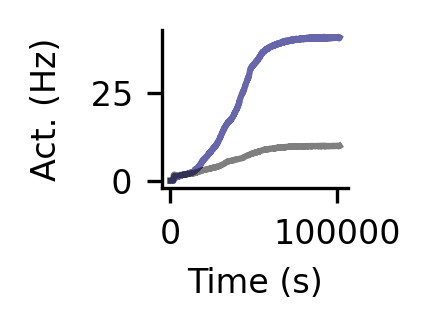

In [57]:
lam = 1
phi = 1
data_path = os.path.expanduser('~/data/lpl/spiking_no_ei_plasticity/tau600_lam%g_phi%g/recurrent/'%(lam,phi))
labels = ["inh", "exc"]
colz = ["#020072", "black"]
alphaz=[0.6, 0.5]
prates = [ np.loadtxt('%s/%s.0.prate'%(data_path,prefix)) for prefix in labels ]

fig=plt.figure(figsize=(0.8,0.7), dpi=300)
ax=plt.subplot(1,1,1)
for l,r,c,a in zip(labels,prates,colz,alphaz):
    plt.plot(r[1:,0],r[1:,1],label=l,color=c,alpha=a)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%3d"))
# plt.legend(frameon=False, fontsize=6, handlelength=0.8, loc=(0.4, 0.45))
# plt.ylim(0,3)
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Act. (Hz)", fontsize=8)
# plt.title('Hebb off', fontsize=10)
sns.despine()
plt.savefig(os.path.join(outputdir,'diff_slowness_rates_inhib_fixed.pdf'), bbox_inches='tight')

## Supplementary figure

In [58]:
def make_suppl_fig(data_paths, labels, outputdir, runid, nb_inputs=500, nb_units=100, test_split=0.05, t_start=None, inhs=[False], quiet=False):
    
    # print("Plotting data ...")
    marker_size = 0.8
    lw = 0.5
    alpha = 0.7
    fig = plt.figure(figsize=(4.2,1.7*len(data_paths)), dpi=150)
    gs = GridSpec(1+len(data_paths),3, width_ratios=[2,1,0.3])

    for k, data_path in enumerate(data_paths):
        # print("Processing %s ..."%data_path)
        sin  = auf.AurynBinarySpikeView('%s/input_group.*.spk'%data_path)
        exc_out = auf.AurynBinarySpikeView('%s/exc.*.spk'%data_path)
        
        t_start = sin.t_max-duration
        t_end   = t_start+duration
        print("t_start=%f, t_end=%f"%(t_start,t_end))

        input_spikes = sin.get_spikes(t_start, t_end)
        exc_spikes   = exc_out.get_spikes(t_start, t_end)
        # activity = np.zeros((int((t_end-t_start)/dt),nb_units))
        w_mat = mmread("%s/input_con.0.wmat"%data_path).toarray()
        w_mat = bin_weights_per_input_group(w_mat)

        # Bin data ...
        binned_hidden = np.zeros((int((t_end-t_start)/dt),nb_units))
        for t,i in exc_spikes:
            idx = int((t-t_start-1e-4)//dt)
            binned_hidden[idx,i] += 1.0
        
        binned_input = np.zeros((int((t_end-t_start)/dt),nb_inputs//input_group_size))
        for t,i in input_spikes:
            idx = int((t-t_start-1e-4)//dt)
            binned_input[idx,i//input_group_size] += 1.0
            
        # Prepare dataset
        X = binned_hidden
        Y = binned_input
        
        res = []
        for g in range(5):
            dataset = (X,Y[:,g])
            ds_train, ds_test = split_dataset(dataset,split=1.0-test_split)

            lasso = linear_model.Lasso(alpha=0.1)
            lasso.fit(*ds_train)

            y_pred_lasso = lasso.predict(ds_test[0])
            r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
            if not quiet:
                print("r2 on test %i data : %f" %(g, r2_score_lasso))
            res.append(r2_score_lasso)
            
        dataset = (X,Y)
        ds_train, ds_test = split_dataset(dataset, split=1.0-test_split)

        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(*ds_train)

        y_pred_lasso = lasso.predict(ds_test[0])
        r2_score_lasso = r2_score(ds_test[1], y_pred_lasso)
        if not quiet:
            print("r2 on test data : %f" %(r2_score_lasso))
            
        # print("Plotting data ...")
        marker_size = 0.8
        lw = 0.5
        alpha = 0.7

        if t_start is None:
            t_start = sin.t_max-test_split*duration # only plot the held out test data
        else:
            t_start = t_end-test_split*duration # only plot the held out test data
        t_dur = t_end-t_start
        input_spikes = sin.get_spikes(t_start, t_end)
        exc_spikes   = exc_out.get_spikes(t_start, t_end)
        # inh_spikes   = inh_out.get_spikes(t_start, t_end)
        if inhs[k]:
            inh_out = auf.AurynBinarySpikeView('%s/inh.*.spk'%data_path)
            inh_spikes = inh_out.get_spikes(t_start, t_end)

        if k==0:    
            plt.subplot(gs[0])
            plt.title("Input spikes", fontsize=10)
            ar = np.array(input_spikes)
            plt.scatter(ar[:,0]-t_start, ar[:,1], marker='|', s=marker_size, alpha=0.4, c='black', linewidths=lw)
            plt.xlim((0, t_dur))
            plt.ylim((0, nb_inputs))
            plt.ylabel('Input spikes', fontsize=8)
            plt.axis("off")
            
            offset = 50
            offs = np.arange(5)*offset
            plt.subplot(gs[1])
            for i in range(5):
                plt.plot(ds_test[1][:,i]+offs[i], color=colors[i], alpha=alphas[i])
            plt.xlabel('Time (s)')
            plt.ylabel('Binned input')
            plt.title("Input signals", fontsize=10)
            plt.ylim((0,5*offset))
            plt.axis("off")
   
    
        plt.subplot(gs[3+k*3])
        if inhs[k] and len(inh_spikes):
            ar = np.array(inh_spikes)
            plt.scatter(ar[:,0]-t_start, ar[:,1], marker='|', s=marker_size, alpha=alpha, c='#020072', linewidths=lw)
        if len(exc_spikes):
            ar = np.array(exc_spikes)
            plt.scatter(ar[:,0]-t_start, 30 + ar[:,1], marker='|', s=marker_size, alpha=alpha, c='black', linewidths=lw)
        plt.xlim((0, t_dur))
        # plt.ylim((,100))
        plt.title("Network activity - " + labels[k], fontsize=10)
        plt.ylabel('Neurons')
        plt.axis("off")
        

        plt.subplot(gs[4+k*3])    
        plt.title("Reconstruction", fontsize=10)
        for i in range(5):
            plt.plot(y_pred_lasso[:,i]+offs[i], color=colors[i], alpha=alphas[i])
        plt.xlabel('Time (s)')
        plt.ylabel('Reconstruction')
        plt.ylim((0,5*offset))
        plt.axis("off")
        
        ax = plt.subplot(gs[5+k*3])  
        y_pos = np.arange(5)
        ax.barh(y_pos, res, color="gray", align="center")
        ax.set_yticks([])
        # ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('$R^2$', fontsize=10, labelpad=-1)
        ax.set_xlim((0,1.0))

    sns.despine()
    plt.tight_layout()
    plt.savefig("%s/%s_fig.png"%(outputdir,runid))
    plt.savefig("%s/%s_fig.pdf"%(outputdir,runid))
    # plt.close(fig)

    return res

In [59]:
data_paths = [os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/recurrent/"), 
os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi0/recurrent/"), 
os.path.expanduser("~/data/lpl/spiking/tau600_lam0_phi1/recurrent/"), 
os.path.expanduser("~/data/lpl/spiking/tau600_lam1_phi1/feedforward/"),
os.path.expanduser("~/data/lpl/spiking_no_ei_plasticity/tau600_lam1_phi1/recurrent/")]

labels = ["LPL", "Pred. off", "Hebb off", "Inhib. off", "Inhib. fixed"]

inhs = [True, True, True, False, True]

t_start=101699.999100, t_end=101799.999100
t_start=101699.999100, t_end=101799.999100
t_start=101699.999100, t_end=101799.999100
t_start=101699.999100, t_end=101799.999100
t_start=101699.999100, t_end=101799.999100


[0.01578796438526131,
 0.5853744600699364,
 0.14295545346111416,
 0.6437030210237078,
 0.2064233626193236]

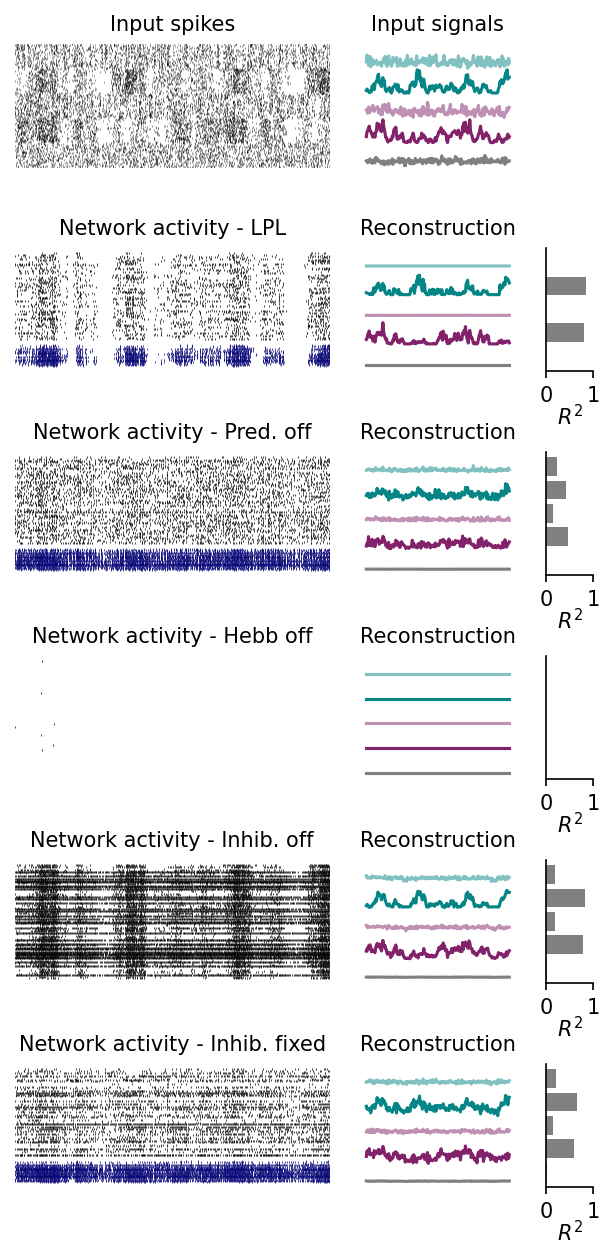

In [60]:
nb_units = 100
make_suppl_fig(data_paths, labels, outputdir, "suppl_full", nb_units=nb_units, inhs=inhs, quiet=True)